### Natural Language Processing
We will train a supervised model to predict if a movie has a positive or a negative review.

####  **Dataset loading & dev/test splits**

**1.0) Load the movie reviews dataset from NLTK library**

In [1]:
import nltk
nltk.download("movie_reviews")
import pandas as pd
from nltk.corpus import movie_reviews
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop = stopwords.words('english')
import string
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/shijia_huang/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shijia_huang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shijia_huang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
negative_fileids = movie_reviews.fileids('neg')
positive_fileids = movie_reviews.fileids('pos')

pos_document = [(' '.join(movie_reviews.words(file_id)),category) for file_id in movie_reviews.fileids() for category in movie_reviews.categories(file_id) if category == 'pos']
neg_document = [(' '.join(movie_reviews.words(file_id)),category) for file_id in movie_reviews.fileids() for category in movie_reviews.categories(file_id) if category == 'neg']

# List of postive and negative reviews
pos_list = [pos[0] for pos in pos_document]
neg_list = [neg[0] for neg in neg_document]

**1.1) Make a data frame that has reviews and its label**

In [3]:
pos = pd.DataFrame({'review': pos_list, 'sentiment' : 'positive'})
neg = pd.DataFrame({'review': neg_list, 'sentiment': 'negative'})

df = pos.append(neg)
df.head() 

,review,sentiment
0,films adapted from comic books have had plenty...,positive
1,every now and then a movie comes along from a ...,positive
2,you ' ve got mail works alot better than it de...,positive
3,""" jaws "" is a rare film that grabs your attent...",positive
4,moviemaking is a lot like being the general ma...,positive


**1.2 Visualize the class distribution of the movie reviews**

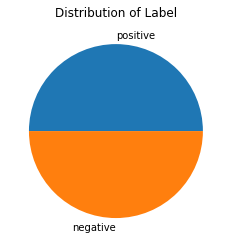

In [4]:
import matplotlib.pyplot as plt
ct = df['sentiment'].value_counts()

plt.pie(ct,labels = ct.index)
plt.title("Distribution of Label")
plt.show()


**1.3) Create a development & test split (80/20 ratio):**

In [5]:
from sklearn.model_selection import train_test_split # Import train_test_split function
df_X = df.drop(columns = ['sentiment'], axis = 1)
df_y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y,test_size=0.2, random_state=0)

print('development features shape:', X_train.shape)
print('test featrues shape:', X_test.shape)


development features shape: (1600, 1)
test featrues shape: (400, 1)


#### **Data preprocessing**
Data preprocessing before we tokenize the data: remove `#` symbol, hyperlinks, stop words & punctuations from the data.

**1.4) Replace the `#` symbol with '' in every review**

In [6]:
X_train['new_review'] = X_train['review'].str.replace('#','')
X_test['new_review'] = X_test['review'].str.replace('#','')


**1.5) Replace hyperlinks with '' in every review**

**1.6) Remove all stop words**

In [7]:
def removeSw(text):
    text_tokens = text.split()
    tokens_without_sw = [word for word in text_tokens if not word.lower() in stop]
    return " ".join(tokens_without_sw)


X_train['new_review_sw'] = [removeSw(review) for review in X_train['new_review']]
X_test['new_review_sw'] = [removeSw(review) for review in X_test['new_review']]
    

**1.7) Remove all punctuations**

In [8]:
X_train['new_review_p'] = X_train['new_review_sw'].str.replace('[^\w\s]','')
X_test['new_review_p'] = X_test['new_review_sw'].str.replace('[^\w\s]','')


/Users/shijia_huang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/shijia_huang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


**1.8) Apply stemming on the development & test datasets using Porter algorithm**

In [9]:
porter = PorterStemmer()

def stemSentence(sentence):
    token_words = word_tokenize(sentence)
    stem_sentence = [porter.stem(word) for word in token_words]
    return " ".join(stem_sentence)

X_train['new_review_stem'] = [stemSentence(review) for review in X_train['new_review_p']]
X_test['new_review_stem'] = [stemSentence(review) for review in X_test['new_review_p']]


In [10]:
X_train_clean = pd.DataFrame(X_train['new_review_stem'])
X_test_clean = pd.DataFrame(X_test['new_review_stem'])

#### **Model training**

**1.9) Create Bag of Words features for each review in the development dataset**

In [11]:
vector = CountVectorizer()
X_train_bag = vector.fit_transform(X_train_clean['new_review_stem']) 
X_test_bag = vector.transform(X_test_clean['new_review_stem'])


**1.10) Train a Logistic Regression model on the development dataset**

In [12]:
lr = LogisticRegression().fit(X_train_bag, y_train)
lr.score(X_test_bag, y_test)


0.8275

**1.11) Create TF-IDF features for each review in the development dataset**

In [13]:
vector = TfidfVectorizer(stop_words = 'english')

X_train_TFIDF = vector.fit_transform(X_train_clean['new_review_stem']) 
X_test_TFIDF = vector.transform(X_test_clean['new_review_stem'])


**1.12) Train the Logistic Regression model on the development dataset with TF-IDF features**

In [14]:
lr = LogisticRegression().fit(X_train_TFIDF, y_train)
lr.score(X_test_TFIDF, y_test)


0.8375

**1.13) Compare the performance of the two models on the test dataset. Explain the difference**

#### The performance of TFIDF (0.8375) is higher than than that of Bag of Words(0.8275). TFIDF compares how many times a word appears in text versus how many text the word appears in, and decrease the combined weight of similar words appearing in texts. Bag of words does not implement any fancy functions, and just regard each text as a set of its words (with the same weight). Thus the Bag of Words performs slightly worse.
